# Mushroom classification

Dataset source - [UCI ML](https://archive.ics.uci.edu/ml/datasets/Secondary+Mushroom+Dataset)

This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms per species). Each mushroom is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended (the latter class was combined with the poisonous class).

Будем использовать этот датасет для определения съедобности и несъедобности грибов.


## Import libraries

In [66]:
! pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached scikit_learn-1.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached numpy-1.23.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached scipy-1.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.4 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pythonwhat 2.23.1 requires asttokens~=1.1.10, but you have asttokens 2.0.8 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.5.1 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.1.2 which is incompatible.


In [67]:
! pip install catboost

  Using cached catboost-1.0.6-cp38-none-manylinux1_x86_64.whl (76.6 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached plotly-5.10.0-py2.py3-none-any.whl (15.2 MB)
  Using cached matplotlib-3.5.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached scipy-1.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.4 MB)
  Using cached pandas-1.4.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.23.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pytz-2022.2.1-py2.py3-none-any.whl (500 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached fonttools-4.37.1-py3-none-any.whl (957 kB)
  Using cached Pillow-9.2.0-

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)
from sklearn.metrics import (classification_report, 
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             roc_curve, 
                             auc)
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from math import ceil

## Read Data
Нужные нам данные содержатся в secondary_data.csv

In [149]:
df = pd.read_csv('data/secondary_data.csv', sep=';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


Описание всех данных
- **class: poisonous=p, edibile=e (binary)**
- cap-diameter (m): float number in cm
- cap-shape (n): bell=b, conical=c, convex=x, flat=f,sunken=s, spherical=p, others=o
- cap-surface (n): fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
- cap-color (n): brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
- does-bruise-or-bleed (n): bruises-or-bleeding=t,no=f
- gill-attachment (n): adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
- gill-spacing (n): close=c, distant=d, none=f
- gill-color (n): see cap-color + none=f
- stem-height (m): float number in cm
- stem-width (m): float number in mm
- stem-root (n): bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
- stem-surface (n): see cap-surface + none=f
- stem-color (n): see cap-color + none=f
- veil-type (n): partial=p, universal=u
- veil-color (n): see cap-color + none=f
- has-ring (n): ring=t, none=f
- ring-type (n): cobwebby=c, evanescent=e, flaring=r, grooved=g,large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
- spore-print-color (n): see cap color
- habitat (n): grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
- season (n): spring=s, summer=u, autumn=a, winter=w

Уберем признаки, которые сложно обнаружить поверхносто-визуально при сборе:
- cap-surface
- does-bruise-or-bleed
- gill-attachment
- stem-root
- stem-surface
- veil-color
- veil-type
- spore-print-color

In [151]:
del_cols = ['cap-surface', 'does-bruise-or-bleed', 'gill-attachment', 
            'stem-root', 'stem-surface', 'veil-color', 
            'veil-type', 'spore-print-color']
df.drop(del_cols, axis=1, inplace=True)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   class         61069 non-null  object 
 1   cap-diameter  61069 non-null  float64
 2   cap-shape     61069 non-null  object 
 3   cap-color     61069 non-null  object 
 4   gill-spacing  36006 non-null  object 
 5   gill-color    61069 non-null  object 
 6   stem-height   61069 non-null  float64
 7   stem-width    61069 non-null  float64
 8   stem-color    61069 non-null  object 
 9   has-ring      61069 non-null  object 
 10  ring-type     58598 non-null  object 
 11  habitat       61069 non-null  object 
 12  season        61069 non-null  object 
dtypes: float64(3), object(10)
memory usage: 6.1+ MB


## EDA
### Missing data

In [153]:
df.isna().sum()/df.shape[0]

class           0.000000
cap-diameter    0.000000
cap-shape       0.000000
cap-color       0.000000
gill-spacing    0.410405
gill-color      0.000000
stem-height     0.000000
stem-width      0.000000
stem-color      0.000000
has-ring        0.000000
ring-type       0.040462
habitat         0.000000
season          0.000000
dtype: float64

В данных отсутствуют только категориальные переменные. Заменим NA специальным значением не встречающимся нигде: "na"

In [154]:
df.fillna('na', inplace=True)
df.isna().sum()

class           0
cap-diameter    0
cap-shape       0
cap-color       0
gill-spacing    0
gill-color      0
stem-height     0
stem-width      0
stem-color      0
has-ring        0
ring-type       0
habitat         0
season          0
dtype: int64

In [155]:
df['class'].value_counts(normalize=True)

p    0.554913
e    0.445087
Name: class, dtype: float64

В данных нет сильного дисбаланса классов.

## Numeric variables

In [124]:
df.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


Посмотрим на распределение числовых переменных в разрезе классов.

In [76]:
num_vars = ['cap-diameter', 'stem-height', 'stem-width']
num_long = df[['class'] + num_vars].melt(id_vars='class')

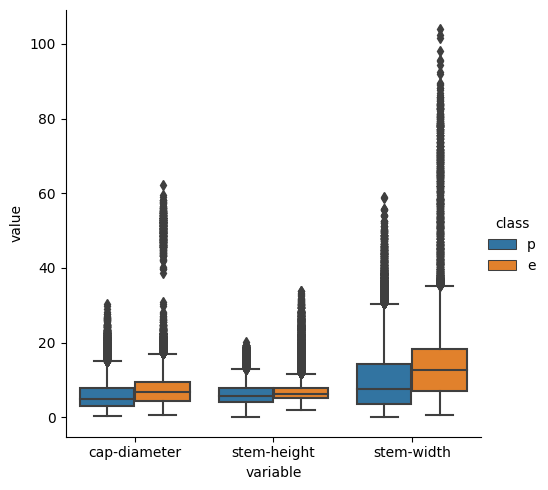

In [77]:
sns.catplot(data=num_long, kind='box', x='variable', y='value', hue='class')
plt.show()

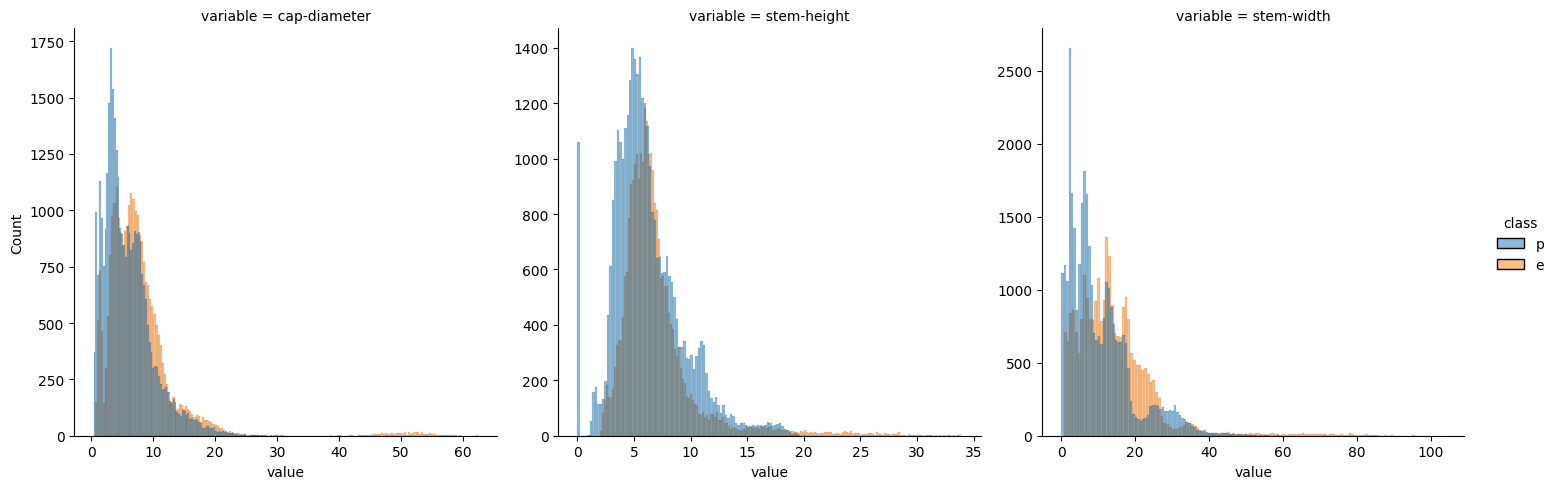

In [78]:
sns.displot(data=num_long, kind='hist', 
            x='value', hue='class', 
            col='variable', alpha=0.5,
            facet_kws={'sharey':False, 'sharex': False}, 
            common_bins=False)
plt.show()

## Categorical variables

In [156]:
list(df.columns)[1:]

['cap-diameter',
 'cap-shape',
 'cap-color',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [157]:
cat_vars = list(df.columns)[1:]
for num in num_vars:
    cat_vars.remove(num)
cat_long = df[['class'] + cat_vars].melt(id_vars='class')

In [158]:
len(cat_vars)
ceil(len(cat_vars)/2)

5

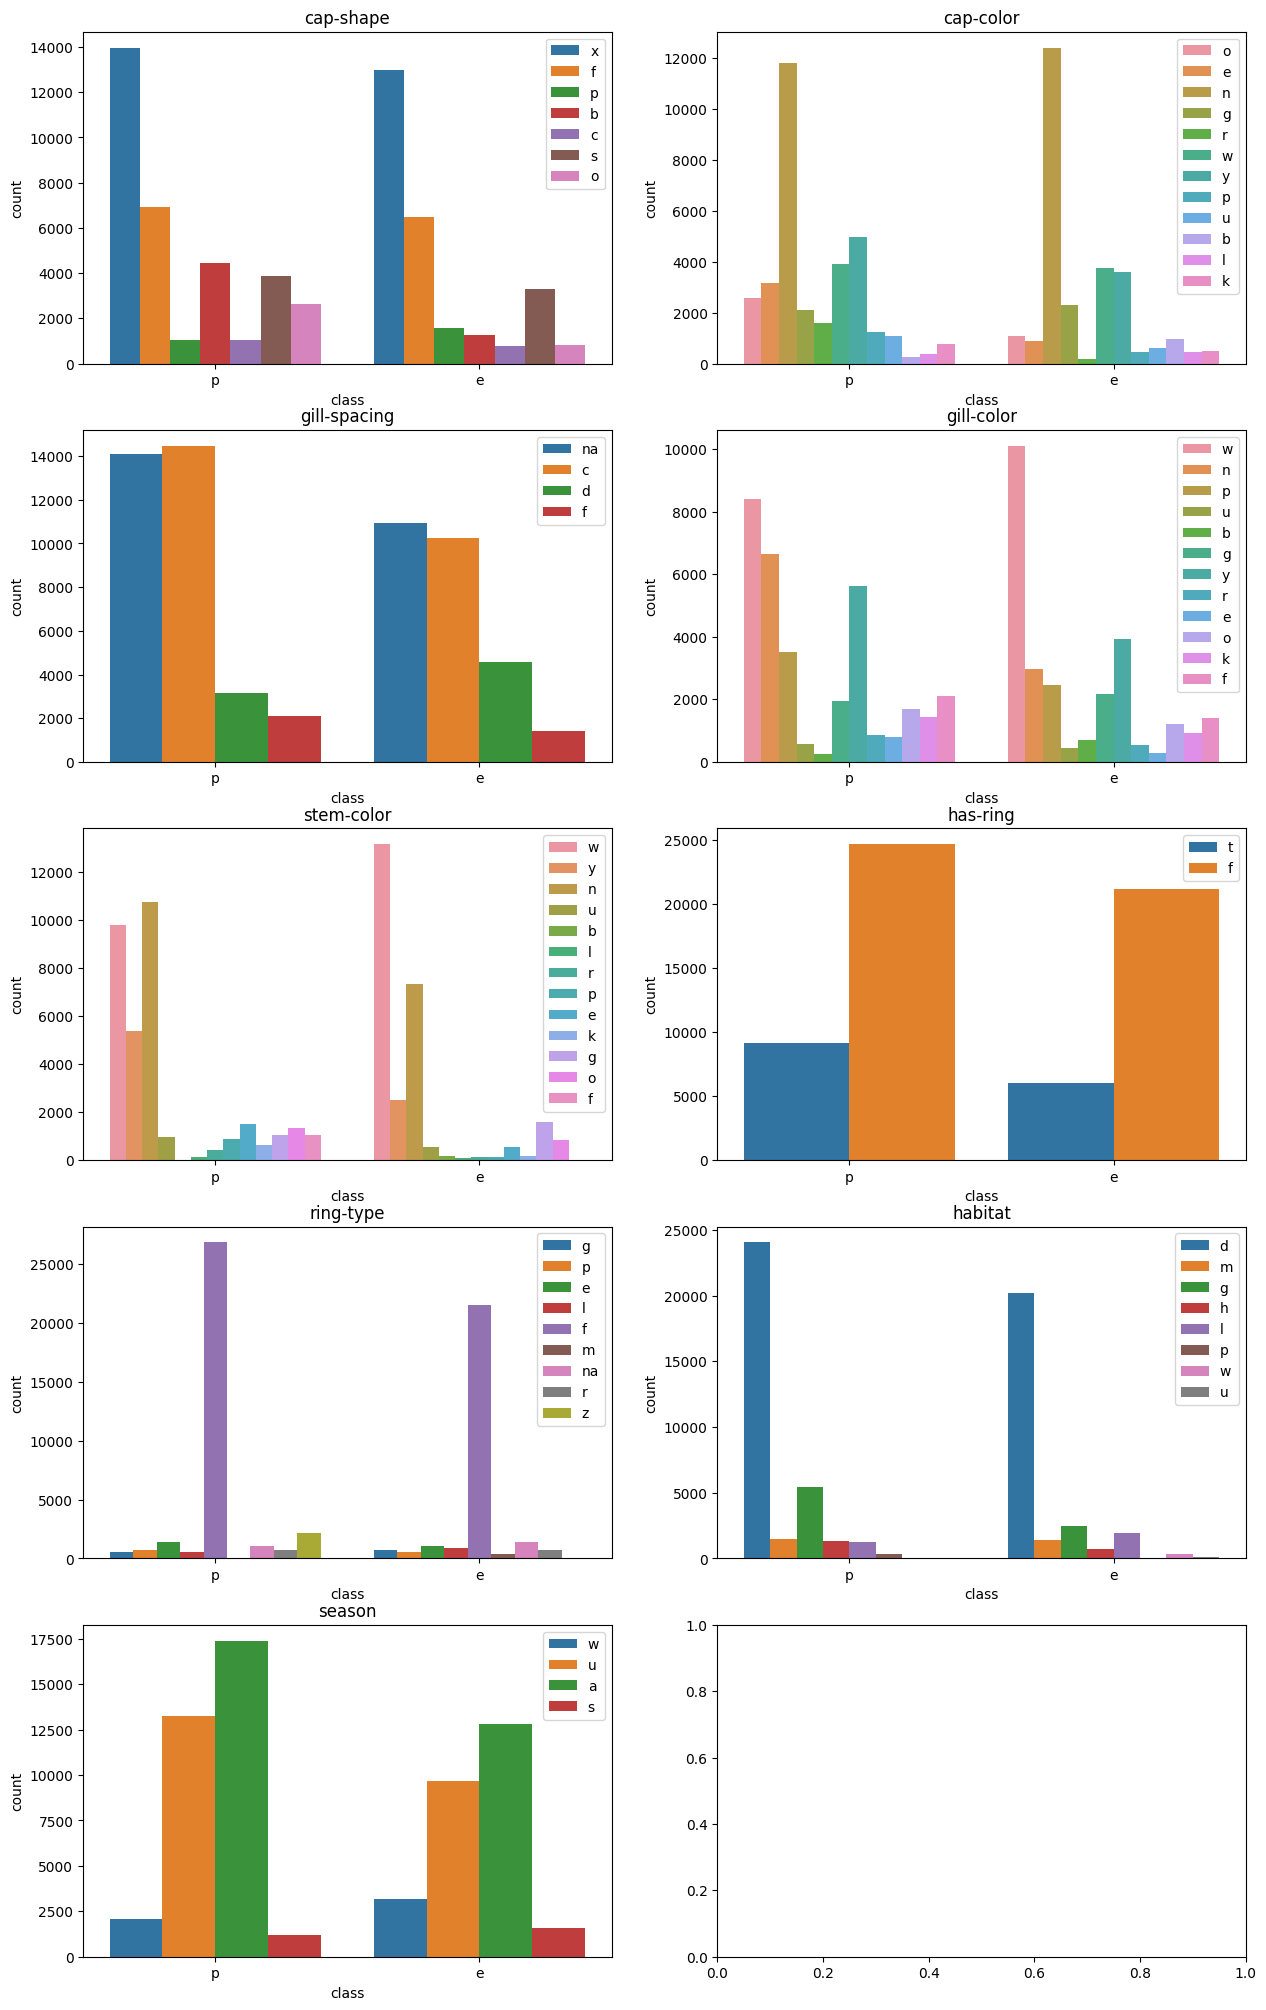

In [159]:
fig_rows = ceil(len(cat_vars)/2)
fig, axes = plt.subplots(fig_rows, 2)
ax = axes.flatten()
fig.set_size_inches(15, 5*fig_rows)
for i, cat in enumerate(cat_vars):
    sns.countplot(data=df, x='class', hue=cat, ax=ax[i])
    ax[i].set_title(cat)
    ax[i].legend(loc='upper right')
plt.show()

## Pre-processing
### Categorical feature encoding
Закодируем категориальные фичи

In [160]:
for cat in cat_vars:
    df[cat] = df[cat].astype('category')

In [161]:
#enc = OneHotEncoder()
enc = OrdinalEncoder()
cat_X = enc.fit_transform(df[cat_vars])
X = pd.concat([df[num_vars], pd.DataFrame(cat_X, columns=enc.get_feature_names_out())], axis=1)

Закодируем целевую переменную
- 0 - несъедобный/ядовитый (p)
- 1 - съедобный (e)

In [162]:
df['class'] = df['class'].map({'e': 1, 'p': 0})

In [163]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, criterion='gini')
clf.fit(X, df['class'])
pd.DataFrame(clf.feature_importances_, index = list(X.columns), columns = ['feature importance']).sort_values('feature importance', ascending = False)

,feature importance
gill-color,0.184301
stem-width,0.169383
ring-type,0.113985
gill-spacing,0.100814
stem-height,0.093909
stem-color,0.084376
cap-diameter,0.081243
cap-color,0.067932
cap-shape,0.056197
habitat,0.034940


In [164]:
from sklearn.metrics import classification_report
pred = clf.predict(X)
print(classification_report(df['class'], pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     33888
           1       0.88      0.87      0.88     27181

    accuracy                           0.89     61069
   macro avg       0.89      0.89      0.89     61069
weighted avg       0.89      0.89      0.89     61069



###  Train-Test split

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, df['class'], 
                                                    test_size=0.3, 
                                                    random_state=777)

#### CatBoost

## Modeling

In [211]:
def calc_metrics(description, test, pred):
    return dict(
        description=description,
        accuracy=accuracy_score(test, pred),
    	prescision=precision_score(test, pred),
    	recall=recall_score(y_test, pred),
    	f1_score=f1_score(test, pred)
    )

def draw_roc_auc(fpr, tpr, auc, ax):
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.plot(fpr, tpr, label=f'ROC curve (auc = {auc})')
    ax.set(
        xlabel = 'False Positive Rate',
        ylabel = 'True Positive Rate'
    )
    ax.legend(loc='lower right')

### Default

#### sklearn

In [189]:
sk_gb = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = sk_gb.predict(X_test)
y_pred_proba = sk_gb.predict_proba(X_test)
sk = {'alg': 'sklearn',
      'y_pred': y_pred, 
      'y_pred_proba': y_pred_proba}

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     10068
           1       0.86      0.88      0.87      8253

    accuracy                           0.88     18321
   macro avg       0.88      0.88      0.88     18321
weighted avg       0.88      0.88      0.88     18321



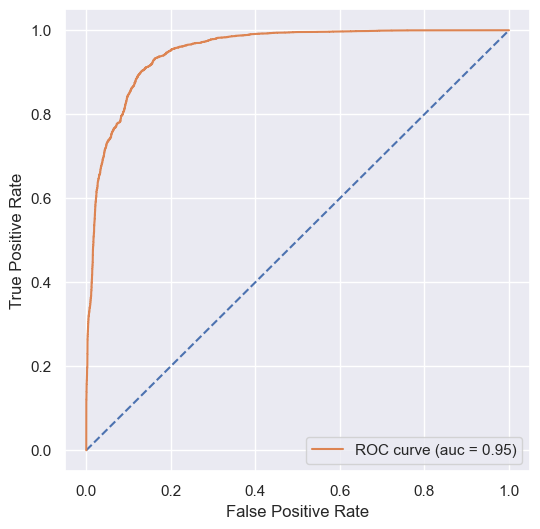

In [213]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
sk_auc = auc(fpr, tpr)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
sns.set_theme()
draw_roc_auc(fpr, tpr, round(sk_auc, 2), ax)
plt.show()

#### XGBoost

In [215]:
xgbc = XGBClassifier().fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
y_pred_proba = xgbc.predict_proba(X_test)
xgb = {'alg': 'XGBoost',
       'y_pred': y_pred, 
       'y_pred_proba': y_pred_proba}

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10068
           1       0.99      1.00      1.00      8253

    accuracy                           1.00     18321
   macro avg       1.00      1.00      1.00     18321
weighted avg       1.00      1.00      1.00     18321



#### CatBoost

In [182]:
cbc = CatBoostClassifier(logging_level='Silent').fit(X_train, y_train)
y_pred = cbc.predict(X_test)
y_pred_proba = cbc.predict_proba(X_test)
cb = {'alg': 'CatBoost',
      'y_pred': y_pred, 
      'y_pred_proba': y_pred_proba}
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10068
           1       1.00      1.00      1.00      8253

    accuracy                           1.00     18321
   macro avg       1.00      1.00      1.00     18321
weighted avg       1.00      1.00      1.00     18321



#### LightGBM

In [183]:
lgbmc = CatBoostClassifier(logging_level='Silent').fit(X_train, y_train)
y_pred = lgbmc.predict(X_test)
y_pred_proba = lgbmc.predict_proba(X_test)
lgbm = {'alg': 'LightGBM',
        'y_pred': y_pred, 
        'y_pred_proba': y_pred_proba}
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10068
           1       1.00      1.00      1.00      8253

    accuracy                           1.00     18321
   macro avg       1.00      1.00      1.00     18321
weighted avg       1.00      1.00      1.00     18321



Хуже всех себя показала реализация градиентного бустинга в sklearn. Все остальные даели великолепные разультаты "из коробки"

### Cross Validation